In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the dataset
df = pd.read_csv("../Data/RADCURE_Clinical_v04_20241219.csv")

In [3]:
# Clean and preprocess the dataset

# Subset and rename relevant columns
df = df[['patient_id', 'Age', 'Stage', 'Chemo', 'Length FU', 'Status']].copy()
df.rename(columns={'Length FU': 'time', 'Status': 'event'}, inplace=True)

df['event'] = df['event'].str.strip().str.lower().apply(lambda x: 1 if x in ['dead', 'deceased'] else 0)

# Group Stage
def group_stage(stage):
    if pd.isna(stage):
        return np.nan
    if str(stage).startswith(('I', 'II')):
        return 'Stage I–II'
    return 'Stage III–IV'

df['Stage_Group'] = df['Stage'].apply(group_stage)

# Drop missing rows
df = df.dropna(subset=['time', 'event', 'Age', 'Stage_Group', 'Chemo'])

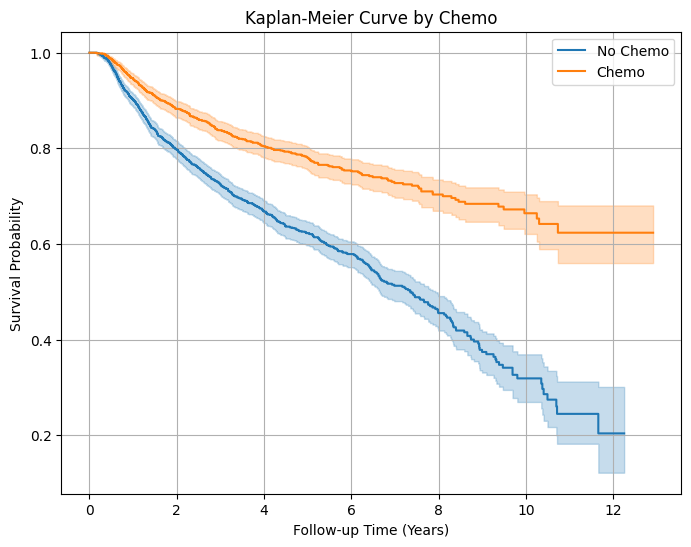

In [4]:
# Kaplan-Meier Analysis - Chemo
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Simplify Chemo to none vs treated
df['Chemo_Simple'] = df['Chemo'].apply(lambda x: 'No Chemo' if x.lower() == 'none' else 'Chemo')

for group in df['Chemo_Simple'].unique():
    ix = df['Chemo_Simple'] == group
    kmf.fit(df.loc[ix, 'time'], df.loc[ix, 'event'], label=group)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Curve by Chemo")
plt.xlabel("Follow-up Time (Years)")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()

In [5]:
# Log-rank test
g1 = df[df['Chemo_Simple'] == 'Chemo']
g2 = df[df['Chemo_Simple'] == 'No Chemo']
results = logrank_test(g1['time'], g2['time'], g1['event'], g2['event'])
print(f"Log-rank test (Chemo): p = {results.p_value:.4f}")

Log-rank test (Chemo): p = 0.0000


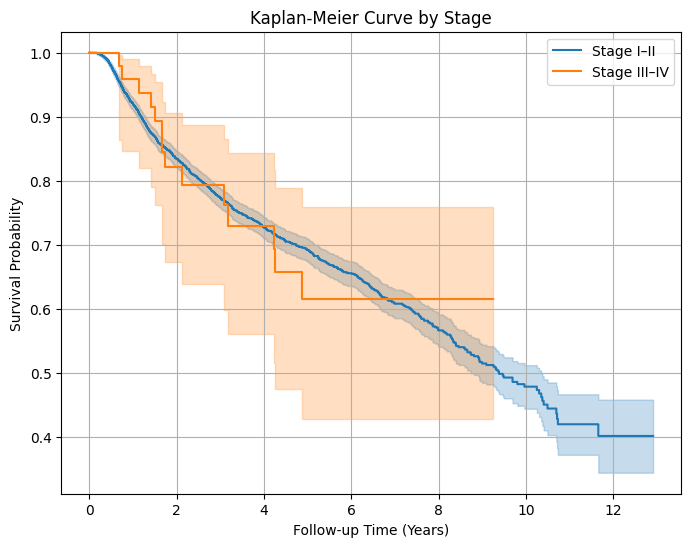

Log-rank test (Stage): p = 0.9006


In [6]:
# Kaplan-Meier Analysis – Stage Group
plt.figure(figsize=(8, 6))
for group in df['Stage_Group'].unique():
    ix = df['Stage_Group'] == group
    kmf.fit(df.loc[ix, 'time'], df.loc[ix, 'event'], label=group)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Curve by Stage")
plt.xlabel("Follow-up Time (Years)")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()

# Log-rank test
g1 = df[df['Stage_Group'] == 'Stage I–II']
g2 = df[df['Stage_Group'] == 'Stage III–IV']
results = logrank_test(g1['time'], g2['time'], g1['event'], g2['event'])
print(f"Log-rank test (Stage): p = {results.p_value:.4f}")